In [1]:
import numpy as np
import matplotlib.pyplot as plt

from algorithms.gam import gam
from algorithms.lv_hba import lv_hba
from algorithms.ours import ours

from utils import *

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
plt.rcParams.update({'font.size': 28})
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False
cmap = plt.get_cmap("tab10")

In [4]:
epochs = 100
seeds = 10

In [5]:
hparams = {
    'lv_hba': {
        'alpha': 0.01,
        'gama1': 0.1,
        'gama2': 0.1,
        'yita': 0.001
    },
    'gam': {
        'alpha': 0.05,
        'epsilon': 0.005
    },
    'ours': {
        'gam': 8,
        'eta': 0.01
    }
}

# Dataset Diabetes

In [6]:
dataset_name = "diabetes"
data = load_diabetes()

n_train = 500
n_val = 150

In [7]:
metrics_diabetes = {}
variables_diabetes = {}

algs = ['ours', 'lv_hba', 'gam']

for a in algs:
    metrics_diabetes[a] = []
    variables_diabetes[a] = []

for seed in range(seeds):

    print(f"Starting seed {seed+1}/{seeds}: ", end="")

    x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, seed, n_train, n_val)

    for alg in algs:
        print(f"{alg}", end=" ")

        metrics_seed, variables_seed = eval(alg)(x_train, y_train, x_val, y_val, x_test, y_test, hparams[alg], epochs, verbose=False)
        metrics_diabetes[alg].append(metrics_seed)
        variables_diabetes[alg].append(variables_seed)
    print("DONE")

Starting seed 1/10: ours lv_hba gam DONE
Starting seed 2/10: ours lv_hba gam DONE
Starting seed 3/10: ours lv_hba gam DONE
Starting seed 4/10: ours lv_hba gam DONE
Starting seed 5/10: ours lv_hba gam DONE
Starting seed 6/10: ours lv_hba gam DONE
Starting seed 7/10: ours lv_hba gam DONE
Starting seed 8/10: ours lv_hba gam DONE
Starting seed 9/10: ours lv_hba gam DONE
Starting seed 10/10: ours lv_hba gam DONE


## Evaluation

In [8]:
results_path = 'Plots_diabetes/'# f'../results/hyperparam_opt/{dataset_name}/'

In [9]:
metrics_lvhba = metrics_diabetes['lv_hba']
metrics_gam = metrics_diabetes['gam']
metrics_ours = metrics_diabetes['ours']

axis_lvhba_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_lvhba])
axis_gam_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_gam])
axis_ours_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_ours])

axis_lvhba = axis_lvhba_all.mean(0)
axis_gam = axis_gam_all.mean(0)
axis_ours = axis_ours_all.mean(0)

axis_iter = np.arange(epochs)

In [10]:
train_acc_lvhba = np.array([[x['train_acc'] for x in metric] for metric in metrics_lvhba])
train_acc_ga = np.array([[x['train_acc'] for x in metric] for metric in metrics_gam])
train_acc_ours = np.array([[x['train_acc_F'] for x in metric] for metric in metrics_ours])

val_acc_lvhba = np.array([[x['val_acc'] for x in metric] for metric in metrics_lvhba])
val_acc_ga = np.array([[x['val_acc'] for x in metric] for metric in metrics_gam])
val_acc_ours = np.array([[x['val_acc_F'] for x in metric] for metric in metrics_ours])

test_acc_lvhba = np.array([[x['test_acc'] for x in metric] for metric in metrics_lvhba])
test_acc_ga = np.array([[x['test_acc'] for x in metric] for metric in metrics_gam])
test_acc_ours = np.array([[x['test_acc_F'] for x in metric] for metric in metrics_ours])

In [11]:
val_loss_lvhba = np.array([[x['val_loss'] for x in metric] for metric in metrics_lvhba])[:,0:]
val_loss_ga = np.array([[x['val_loss'] for x in metric] for metric in metrics_gam])[:,0:]
val_loss_ours = np.array([[x['val_loss_F'] for x in metric] for metric in metrics_ours])[:,0:]

test_loss_lvhba = np.array([[x['test_loss'] for x in metric] for metric in metrics_lvhba])[:,0:]
test_loss_ga = np.array([[x['test_loss'] for x in metric] for metric in metrics_gam])[:,0:]
test_loss_ours = np.array([[x['test_loss_F'] for x in metric] for metric in metrics_ours])[:,0:]

lower_loss_lvhba = np.array([[x['loss_lower'] for x in metric] for metric in metrics_lvhba])[:,1:]
lower_loss_ga = np.array([[x['loss_lower'] for x in metric] for metric in metrics_gam])[:,1:]
lower_loss_ours = np.array([[x['loss_lower'] for x in metric] for metric in metrics_ours])[:,1:]

# constraint_violation_lvhba = np.array([[x['constraint_violation'] for x in metric] for metric in metrics_lvhba])[:,1:]
# constraint_violation_ours = np.array([[x['constraint_violation'] for x in metric] for metric in metrics_ours])[:,1:]

### Measuring Convergence Time
When `(UpperLoss_{t+1}-UpperLoss_t)^2` is smaller than `eps = 1e-10`. We say convergence happen.

In [12]:
print("-------------- Accuracy -------------")
print('Ours: {:0.3f} ({:0.3f})'.format(test_acc_ours[:,-1].mean(),test_acc_ours[:,-1].std()))
print('lvhba: {:0.3f} ({:0.3f})'.format(test_acc_lvhba[:,-1].mean(),test_acc_lvhba[:,-1].std()))
print('gam: {:0.3f} ({:0.3f})'.format(test_acc_ga[:,-1].mean(),test_acc_ga[:,-1].std()))

-------------- Accuracy -------------
Ours: 0.764 (0.020)
lvhba: 0.753 (0.029)
gam: 0.734 (0.026)


In [13]:
eps = 1e-5

diff_val_loss_ours = np.diff(val_loss_ours,axis=1)**2
diff_val_loss_ours[diff_val_loss_ours<eps]=0
converged_id_ours = np.argmin(diff_val_loss_ours,axis = 1)

diff_val_loss_lvhba = np.diff(val_loss_lvhba,axis=1)**2
diff_val_loss_lvhba[diff_val_loss_lvhba<eps]=0
converged_id_lvhba = np.argmin(diff_val_loss_lvhba,axis = 1)

diff_val_loss_ga = np.diff(val_loss_ga,axis=1)**2
diff_val_loss_ga[diff_val_loss_ga<eps]=0
converged_id_ga = np.argmin(diff_val_loss_ga,axis = 1)

time_ours = []
time_lvhba = []
time_ga = []
for i in range(seeds):
    time_ours.append(axis_ours_all[i,converged_id_ours[i]+1])
    time_lvhba.append(axis_lvhba_all[i,converged_id_lvhba[i]+1])
    time_ga.append(axis_gam_all[i,converged_id_ga[i]+1])

time_ours = np.array(time_ours)
time_lvhba = np.array(time_lvhba)
time_ga = np.array(time_ga)
print("-------------- Running Time -------------")
print('Ours: {:0.3f} ({:0.3f})'.format(time_ours.mean(),time_ours.std()))
print('lvhba: {:0.3f} ({:0.3f})'.format(time_lvhba.mean(),time_lvhba.std()))
print('gam: {:0.3f} ({:0.3f})'.format(time_ga.mean(),time_ga.std()))


-------------- Running Time -------------
Ours: 2.880 (0.933)
lvhba: 2.030 (0.167)
gam: 0.737 (0.027)


### Plots

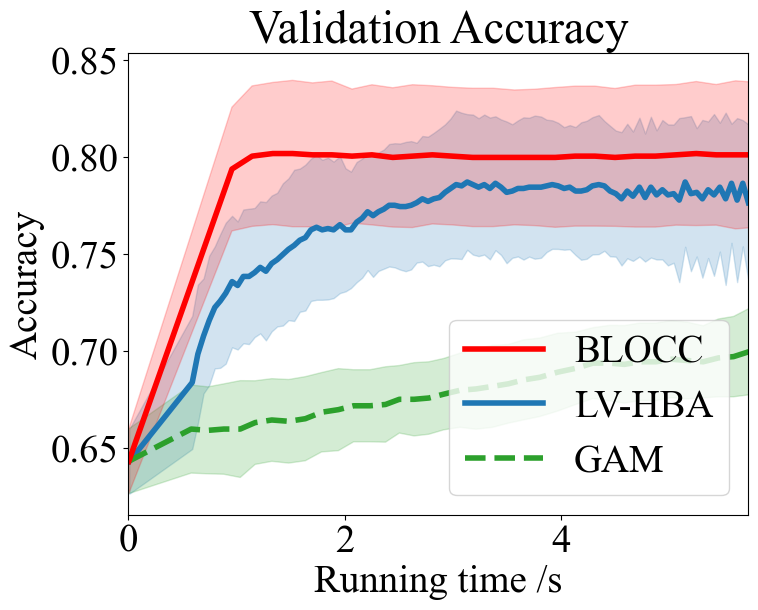

In [14]:
plt.figure(figsize=(8,6))

plt.plot(axis_lvhba,val_acc_lvhba.mean(0),'-', color = cmap(0),linewidth = 4, label="LV-HBA")
plt.fill_between(axis_lvhba,val_acc_lvhba.mean(0)-val_acc_lvhba.std(0),val_acc_lvhba.mean(0)+val_acc_lvhba.std(0), color = cmap(0),alpha=0.2)

plt.plot(axis_gam,val_acc_ga.mean(0),'--', color = cmap(2), linewidth = 4, label="GAM")
plt.fill_between(axis_gam,val_acc_ga.mean(0)-val_acc_ga.std(0),val_acc_ga.mean(0)+val_acc_ga.std(0), color = cmap(2), alpha=0.2)

plt.plot(axis_ours,val_acc_ours.mean(0),'-',color='r',linewidth = 4, label="BLOCC")
plt.fill_between(axis_ours,val_acc_ours.mean(0)-val_acc_ours.std(0),val_acc_ours.mean(0)+val_acc_ours.std(0),color='r', alpha=0.2)

# Get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder the handles and labels as needed
order = [2,0,1]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]

# Create the legend with the new order
plt.legend(ordered_handles, ordered_labels)
              
plt.title('Validation Accuracy')
plt.xlabel('Running time /s')
plt.ylabel("Accuracy")
plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'val_accuracy_running_time.pdf', bbox_inches="tight")

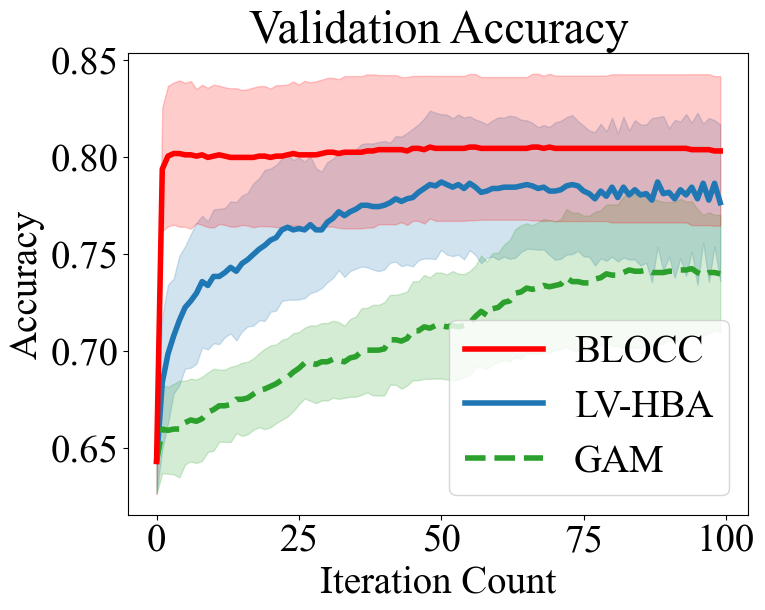

In [15]:
plt.figure(figsize=(8,6))

iter_axis = np.arange(val_acc_ga.shape[1])


plt.plot(axis_iter,val_acc_lvhba.mean(0),'-',color = cmap(0), linewidth = 4,  label="LV-HBA")
plt.fill_between(axis_iter,val_acc_lvhba.mean(0)-val_acc_lvhba.std(0),val_acc_lvhba.mean(0)+val_acc_lvhba.std(0),color = cmap(0), alpha=0.2)

plt.plot(axis_iter,val_acc_ga.mean(0),'--',color = cmap(2),  linewidth = 4, label="GAM")
plt.fill_between(axis_iter,val_acc_ga.mean(0)-val_acc_ga.std(0),val_acc_ga.mean(0)+val_acc_ga.std(0),color = cmap(2), alpha=0.2)

plt.plot(axis_iter,val_acc_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
plt.fill_between(axis_iter,val_acc_ours.mean(0)-val_acc_ours.std(0),val_acc_ours.mean(0)+val_acc_ours.std(0),color = 'r',alpha=0.2)

plt.legend(ordered_handles, ordered_labels)

plt.title('Validation Accuracy')
plt.xlabel('Iteration Count')
plt.ylabel("Accuracy")


plt.savefig(results_path + 'val_accuracy_iteration.pdf', bbox_inches="tight")

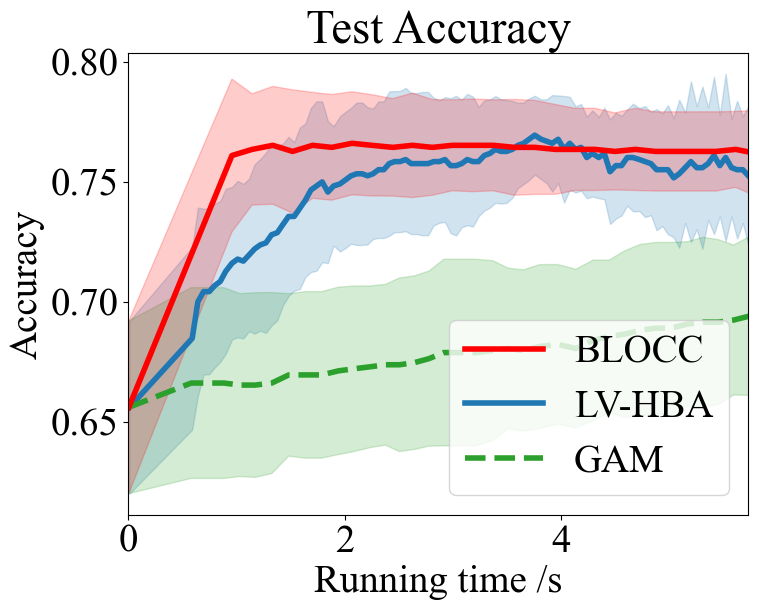

In [16]:
plt.figure(figsize=(8,6))

plt.plot(axis_lvhba,test_acc_lvhba.mean(0),'-',linewidth = 4, color = cmap(0),label="LV-HBA")
plt.fill_between(axis_lvhba,test_acc_lvhba.mean(0)-test_acc_lvhba.std(0),test_acc_lvhba.mean(0)+test_acc_lvhba.std(0),color = cmap(0),alpha=0.2)

plt.plot(axis_gam,test_acc_ga.mean(0),'--',linewidth = 4, color = cmap(2),label="GAM")
plt.fill_between(axis_gam,test_acc_ga.mean(0)-test_acc_ga.std(0),test_acc_ga.mean(0)+test_acc_ga.std(0),color = cmap(2),alpha=0.2)

plt.plot(axis_ours,test_acc_ours.mean(0),'-',linewidth = 4, color = 'r',label="BLOCC")
plt.fill_between(axis_ours,test_acc_ours.mean(0)-test_acc_ours.std(0),test_acc_ours.mean(0)+test_acc_ours.std(0),color = 'r',alpha=0.2)

# Get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Reorder the handles and labels as needed
order = [2,0,1]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
# Create the legend with the new order
plt.legend(ordered_handles, ordered_labels)

plt.title('Test Accuracy')
plt.xlabel('Running time /s')
plt.ylabel("Accuracy")

plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'test_accuracy_running_time.pdf', bbox_inches="tight")

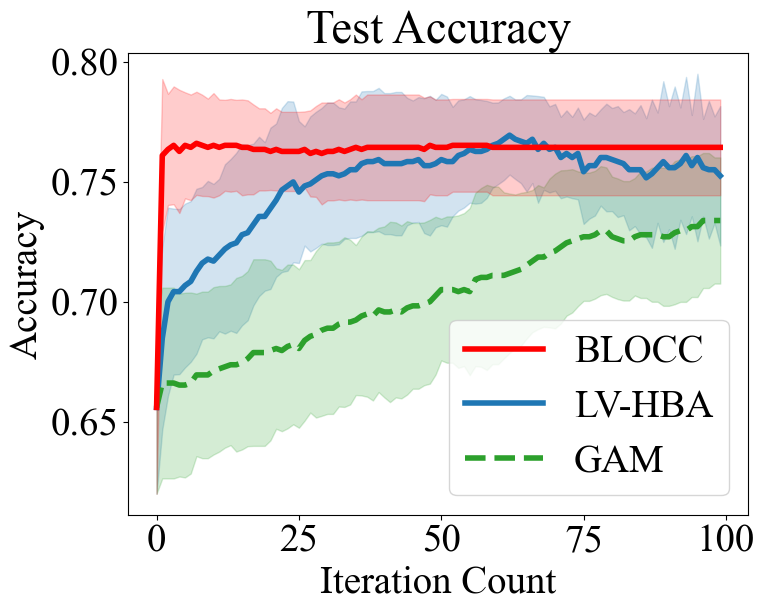

In [17]:
plt.figure(figsize=(8,6))

plt.plot(axis_iter,test_acc_lvhba.mean(0),'-',color = cmap(0),linewidth = 4, label="LV-HBA")
plt.fill_between(axis_iter,test_acc_lvhba.mean(0)-test_acc_lvhba.std(0),test_acc_lvhba.mean(0)+test_acc_lvhba.std(0),color = cmap(0),alpha=0.2)

plt.plot(axis_iter,test_acc_ga.mean(0),'--',color = cmap(2),linewidth = 4, label="GAM")
plt.fill_between(axis_iter,test_acc_ga.mean(0)-test_acc_ga.std(0),test_acc_ga.mean(0)+test_acc_ga.std(0),color = cmap(2),alpha=0.2)


plt.plot(axis_iter,test_acc_ours.mean(0),'-',color = 'r',linewidth = 4, label="BLOCC")
plt.fill_between(axis_iter,test_acc_ours.mean(0)-test_acc_ours.std(0),test_acc_ours.mean(0)+test_acc_ours.std(0),color = 'r',alpha=0.2)


plt.legend(ordered_handles, ordered_labels)

plt.title('Test Accuracy')
plt.xlabel('Iteration Count')
plt.ylabel("Accuracy")
plt.savefig(results_path + 'test_accuracy_iteration.pdf', bbox_inches="tight")

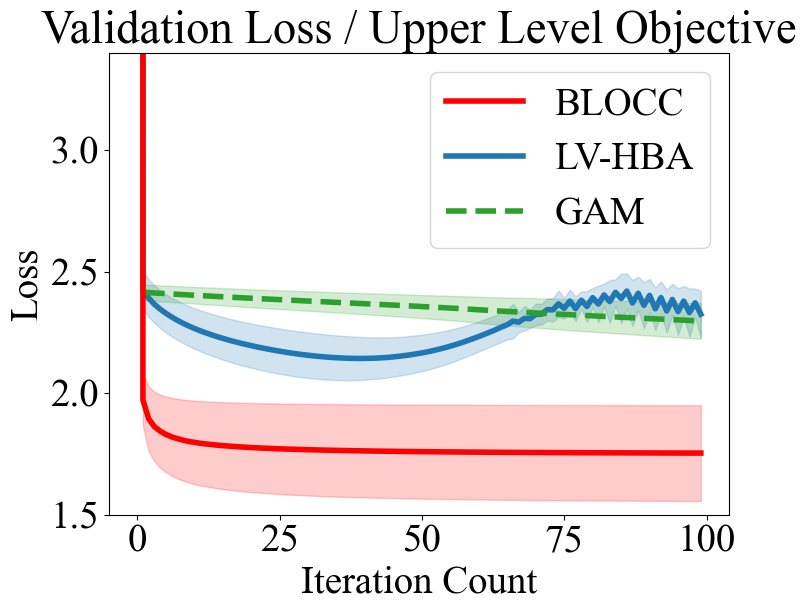

In [18]:
plt.figure(figsize=(8,6))


plt.plot(iter_axis,val_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = val_loss_lvhba.mean(0)-val_loss_lvhba.std(0)
fill_up_LV = val_loss_lvhba.mean(0)+val_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(iter_axis,val_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = val_loss_ga.mean(0)-val_loss_ga.std(0)
fill_dn_GAM = val_loss_ga.mean(0)+val_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(iter_axis,val_loss_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_ours = val_loss_ours.mean(0)-val_loss_ours.std(0)
fill_up_ours = val_loss_ours.mean(0)+val_loss_ours.std(0)
plt.fill_between(iter_axis[1:],fill_dn_ours[1:],fill_up_ours[1:],color = 'r', alpha=0.2)

plt.legend(ordered_handles, ordered_labels)

plt.title('Validation Loss / Upper Level Objective')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")


plt.ylim([1.5,3.4])
plt.savefig(results_path + 'upper_obj_iteration.pdf', bbox_inches="tight")

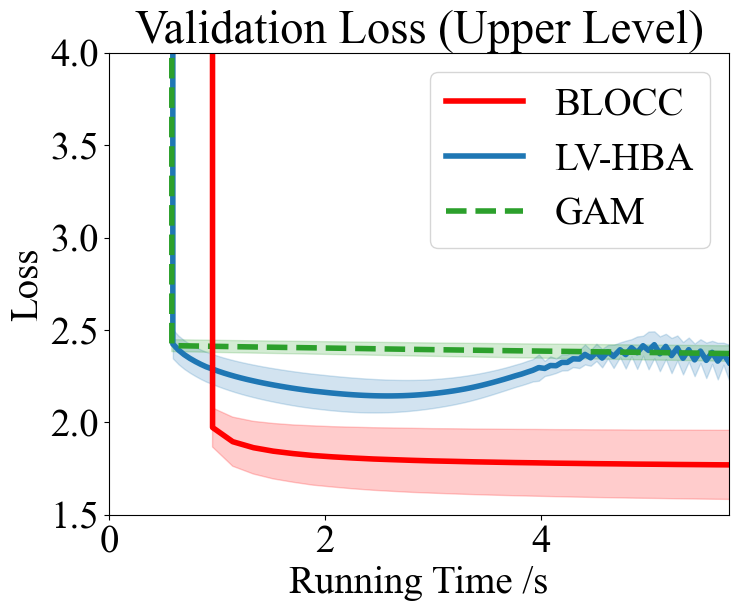

In [19]:
plt.figure(figsize=(8,6))


plt.plot(axis_lvhba,val_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = val_loss_lvhba.mean(0)-val_loss_lvhba.std(0)
fill_up_LV = val_loss_lvhba.mean(0)+val_loss_lvhba.std(0)
plt.fill_between(axis_lvhba[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(axis_gam,val_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = val_loss_ga.mean(0)-val_loss_ga.std(0)
fill_dn_GAM = val_loss_ga.mean(0)+val_loss_ga.std(0)
plt.fill_between(axis_gam[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(axis_ours,val_loss_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_ours = val_loss_ours.mean(0)-val_loss_ours.std(0)
fill_up_ours = val_loss_ours.mean(0)+val_loss_ours.std(0)
plt.fill_between(axis_ours[1:],fill_dn_ours[1:],fill_up_ours[1:],color = 'r', alpha=0.2)

plt.legend(ordered_handles, ordered_labels)
plt.title('Validation Loss (Upper Level)')
plt.xlabel('Running Time /s')
plt.ylabel("Loss")

plt.ylim([1.5,4])
plt.xlim([0,13])
plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'upper_obj_time.pdf', bbox_inches="tight")

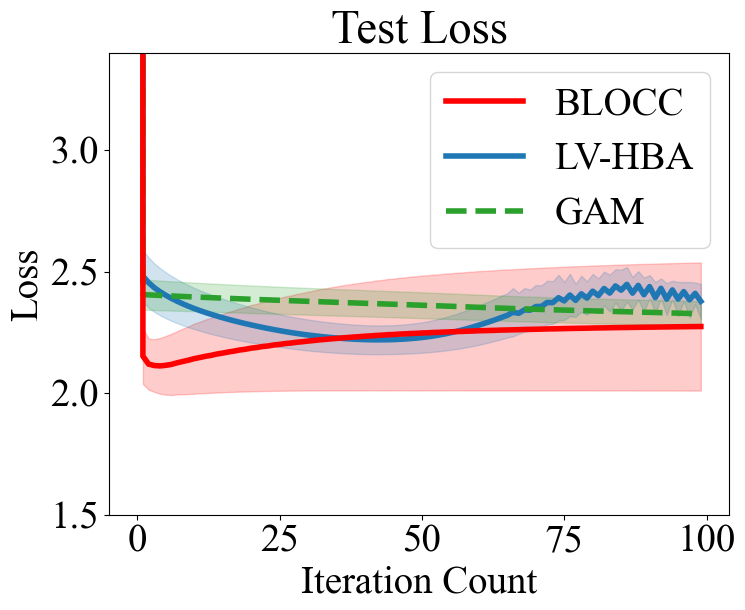

In [20]:
plt.figure(figsize=(8,6))

fill_dn_ours = test_loss_ours.mean(0)-test_loss_ours.std(0)
fill_up_ours = test_loss_ours.mean(0)+test_loss_ours.std(0)
plt.fill_between(iter_axis[1:],fill_dn_ours[1:],fill_up_ours[1:],color = 'r', alpha=0.2)

fill_dn_LV = test_loss_lvhba.mean(0)-test_loss_lvhba.std(0)
fill_up_LV = test_loss_lvhba.mean(0)+test_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

fill_up_GAM = test_loss_ga.mean(0)-test_loss_ga.std(0)
fill_dn_GAM = test_loss_ga.mean(0)+test_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(iter_axis,test_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")

plt.plot(iter_axis,test_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")

plt.plot(iter_axis,test_loss_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")


plt.legend(ordered_handles, ordered_labels)
plt.title('Test Loss')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")

plt.ylim([1.5,3.4])
plt.savefig(results_path + 'test_obj_iteration.pdf', bbox_inches="tight")

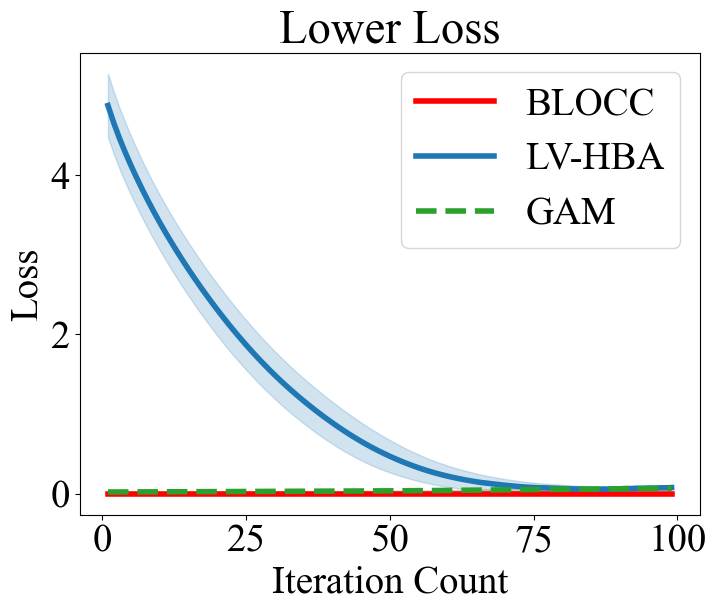

In [21]:
plt.figure(figsize=(8,6))

plt.plot(iter_axis[1:],lower_loss_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
# fill_dn_ours = lower_loss_ours.mean(0)-lower_loss_ours.std(0)
# fill_up_ours = lower_loss_ours.mean(0)+lower_loss_ours.std(0)
# plt.fill_between(iter_axis[1:],fill_dn_ours,fill_up_ours,alpha=0.2)
# the above didn't work as the standard deviation is too small

plt.plot(iter_axis[1:],lower_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = lower_loss_lvhba.mean(0)-lower_loss_lvhba.std(0)
fill_up_LV = lower_loss_lvhba.mean(0)+lower_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV,fill_up_LV,color = cmap(0),alpha=0.2)

plt.plot(iter_axis[1:],lower_loss_ga.mean(0),'--', color = cmap(2),linewidth = 4, label="GAM")
fill_up_GAM = lower_loss_ga.mean(0)-lower_loss_ga.std(0)
fill_dn_GAM = lower_loss_ga.mean(0)+lower_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM,fill_up_GAM,color = cmap(2),alpha=0.2)

plt.legend()
plt.title('Lower Loss')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")

plt.savefig(results_path + 'lower_obj_iteration.pdf', bbox_inches="tight")

# Dataset Fourclass

In [22]:
dataset_name = "fourclass"
data = load_fourclass()

n_train = 500
n_val = 150

In [23]:
metrics_fourclass = {}
variables_fourclass = {}

algs = ['ours', 'lv_hba', 'gam']

for a in algs:
    metrics_fourclass[a] = []
    variables_fourclass[a] = []

for seed in range(seeds):

    print(f"Starting seed {seed+1}/{seeds}: ", end="")

    x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, seed, n_train, n_val)

    for alg in algs:
        print(f"{alg}", end=" ")

        metrics_seed, variables_seed = eval(alg)(x_train, y_train, x_val, y_val, x_test, y_test, hparams[alg], epochs, verbose=False)
        metrics_fourclass[alg].append(metrics_seed)
        variables_fourclass[alg].append(variables_seed)
    print("DONE")

Starting seed 1/10: ours lv_hba gam DONE
Starting seed 2/10: ours lv_hba gam DONE
Starting seed 3/10: ours 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


lv_hba gam DONE
Starting seed 4/10: ours lv_hba gam DONE
Starting seed 5/10: ours lv_hba gam DONE
Starting seed 6/10: ours lv_hba gam DONE
Starting seed 7/10: ours lv_hba gam DONE
Starting seed 8/10: ours lv_hba gam DONE
Starting seed 9/10: ours lv_hba gam DONE
Starting seed 10/10: ours lv_hba gam DONE


## Evaluation

In [24]:
results_path = 'Plots_fourclass/'#f'../results/hyperparam_opt/{dataset_name}/'

In [25]:
metrics_lvhba = metrics_fourclass['lv_hba']
metrics_gam = metrics_fourclass['gam']
metrics_ours = metrics_fourclass['ours']


axis_lvhba_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_lvhba])
axis_gam_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_gam])
axis_ours_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_ours])

axis_lvhba = axis_lvhba_all.mean(0)
axis_gam = axis_gam_all.mean(0)
axis_ours = axis_ours_all.mean(0)

axis_iter = np.arange(epochs)

In [26]:
train_acc_lvhba = np.array([[x['train_acc'] for x in metrics] for metrics in metrics_lvhba])
train_acc_ga = np.array([[x['train_acc'] for x in metrics] for metrics in metrics_gam])
train_acc_ours = np.array([[x['train_acc_F'] for x in metrics] for metrics in metrics_ours])

val_acc_lvhba = np.array([[x['val_acc'] for x in metrics] for metrics in metrics_lvhba])
val_acc_ga = np.array([[x['val_acc'] for x in metrics] for metrics in metrics_gam])
val_acc_ours = np.array([[x['val_acc_F'] for x in metrics] for metrics in metrics_ours])

test_acc_lvhba = np.array([[x['test_acc'] for x in metrics] for metrics in metrics_lvhba])
test_acc_ga = np.array([[x['test_acc'] for x in metrics] for metrics in metrics_gam])
test_acc_ours = np.array([[x['test_acc_F'] for x in metrics] for metrics in metrics_ours])

In [27]:
val_loss_lvhba = np.array([[x['val_loss'] for x in metrics] for metrics in metrics_lvhba])[:,0:]
val_loss_ga = np.array([[x['val_loss'] for x in metrics] for metrics in metrics_gam])[:,0:]
val_loss_ours = np.array([[x['val_loss_F'] for x in metrics] for metrics in metrics_ours])[:,0:]

test_loss_lvhba = np.array([[x['test_loss'] for x in metrics] for metrics in metrics_lvhba])[:,0:]
test_loss_ga = np.array([[x['test_loss'] for x in metrics] for metrics in metrics_gam])[:,0:]
test_loss_ours = np.array([[x['test_loss_F'] for x in metrics] for metrics in metrics_ours])[:,0:]

lower_loss_lvhba = np.array([[x['loss_lower'] for x in metrics] for metrics in metrics_lvhba])[:,1:]
lower_loss_ga = np.array([[x['loss_lower'] for x in metrics] for metrics in metrics_gam])[:,1:]
lower_loss_ours = np.array([[x['loss_lower'] for x in metrics] for metrics in metrics_ours])[:,1:]


### Measuring Convergence Time
When `(UpperLoss_{t+1}-UpperLoss_t)^2` is smaller than `eps = 1e-10`. We say convergence happen.

In [28]:
print("-------------- Accuracy -------------")
print('Ours: {:0.3f} ({:0.3f})'.format(test_acc_ours[:,-1].mean(),test_acc_ours[:,-1].std()))
print('lvhba: {:0.3f} ({:0.3f})'.format(test_acc_lvhba[:,-1].mean(),test_acc_lvhba[:,-1].std()))
print('gam: {:0.3f} ({:0.3f})'.format(test_acc_ga[:,-1].mean(),test_acc_ga[:,-1].std()))

-------------- Accuracy -------------
Ours: 0.760 (0.012)
lvhba: 0.783 (0.021)
gam: 0.733 (0.056)


In [29]:
eps = 1e-5

diff_val_loss_ours = np.diff(val_loss_ours,axis=1)**2
diff_val_loss_ours[diff_val_loss_ours<eps]=0
converged_id_ours = np.argmin(diff_val_loss_ours,axis = 1)

diff_val_loss_lvhba = np.diff(val_loss_lvhba,axis=1)**2
diff_val_loss_lvhba[diff_val_loss_lvhba<eps]=0
converged_id_lvhba = np.argmin(diff_val_loss_lvhba,axis = 1)

diff_val_loss_ga = np.diff(val_loss_ga,axis=1)**2
diff_val_loss_ga[diff_val_loss_ga<eps]=0
converged_id_ga = np.argmin(diff_val_loss_ga,axis = 1)

time_ours = []
time_lvhba = []
time_ga = []
for i in range(seeds):
    time_ours.append(axis_ours_all[i,converged_id_ours[i]+1])
    time_lvhba.append(axis_lvhba_all[i,converged_id_lvhba[i]+1])
    time_ga.append(axis_gam_all[i,converged_id_ga[i]+1])

time_ours = np.array(time_ours)
time_lvhba = np.array(time_lvhba)
time_ga = np.array(time_ga)
print("-------------- Running Time -------------")
print('Ours: {:0.3f} ({:0.3f})'.format(time_ours.mean(),time_ours.std()))
print('lvhba: {:0.3f} ({:0.3f})'.format(time_lvhba.mean(),time_lvhba.std()))
print('gam: {:0.3f} ({:0.3f})'.format(time_ga.mean(),time_ga.std()))

-------------- Running Time -------------
Ours: 0.852 (0.077)
lvhba: 0.832 (0.092)
gam: 0.599 (0.177)


### Plots

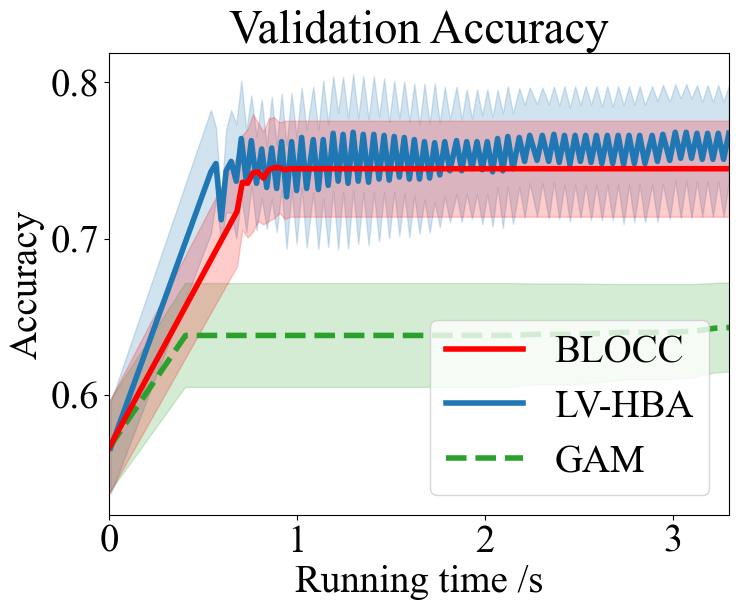

In [30]:
plt.figure(figsize=(8,6))

plt.plot(axis_lvhba,val_acc_lvhba.mean(0),'-', color = cmap(0),linewidth = 4, label="LV-HBA")
plt.fill_between(axis_lvhba,val_acc_lvhba.mean(0)-val_acc_lvhba.std(0),val_acc_lvhba.mean(0)+val_acc_lvhba.std(0), color = cmap(0),alpha=0.2)

plt.plot(axis_gam,val_acc_ga.mean(0),'--', color = cmap(2), linewidth = 4, label="GAM")
plt.fill_between(axis_gam,val_acc_ga.mean(0)-val_acc_ga.std(0),val_acc_ga.mean(0)+val_acc_ga.std(0), color = cmap(2), alpha=0.2)

plt.plot(axis_ours,val_acc_ours.mean(0),'-',color='r',linewidth = 4, label="BLOCC")
plt.fill_between(axis_ours,val_acc_ours.mean(0)-val_acc_ours.std(0),val_acc_ours.mean(0)+val_acc_ours.std(0),color='r', alpha=0.2)

# Get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder the handles and labels as needed
order = [2,0,1]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]

# Create the legend with the new order
plt.legend(ordered_handles, ordered_labels)
              
plt.title('Validation Accuracy')
plt.xlabel('Running time /s')
plt.ylabel("Accuracy")
plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'val_accuracy_running_time.pdf', bbox_inches="tight")

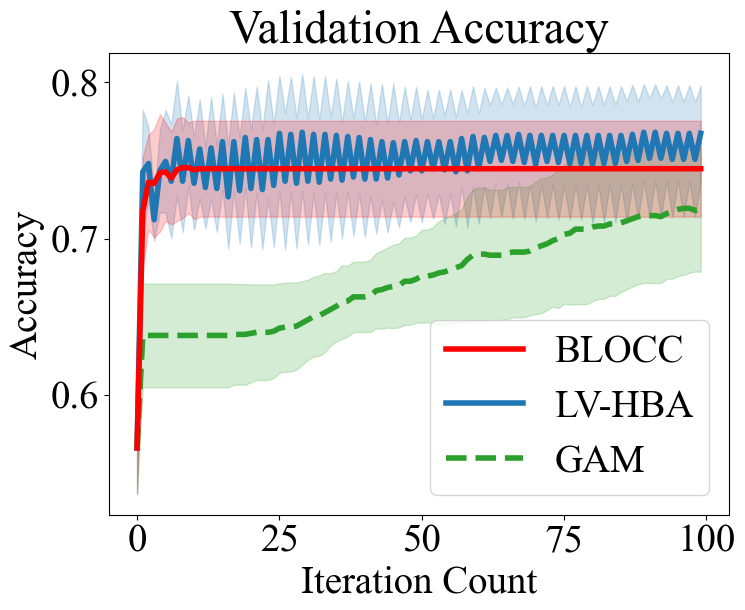

In [31]:
plt.figure(figsize=(8,6))

iter_axis = np.arange(val_acc_ga.shape[1])


plt.plot(axis_iter,val_acc_lvhba.mean(0),'-',color = cmap(0), linewidth = 4,  label="LV-HBA")
plt.fill_between(axis_iter,val_acc_lvhba.mean(0)-val_acc_lvhba.std(0),val_acc_lvhba.mean(0)+val_acc_lvhba.std(0),color = cmap(0), alpha=0.2)

plt.plot(axis_iter,val_acc_ga.mean(0),'--',color = cmap(2),  linewidth = 4, label="GAM")
plt.fill_between(axis_iter,val_acc_ga.mean(0)-val_acc_ga.std(0),val_acc_ga.mean(0)+val_acc_ga.std(0),color = cmap(2), alpha=0.2)

plt.plot(axis_iter,val_acc_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
plt.fill_between(axis_iter,val_acc_ours.mean(0)-val_acc_ours.std(0),val_acc_ours.mean(0)+val_acc_ours.std(0),color = 'r',alpha=0.2)

plt.legend(ordered_handles, ordered_labels)

plt.title('Validation Accuracy')
plt.xlabel('Iteration Count')
plt.ylabel("Accuracy")


plt.savefig(results_path + 'val_accuracy_iteration.pdf', bbox_inches="tight")

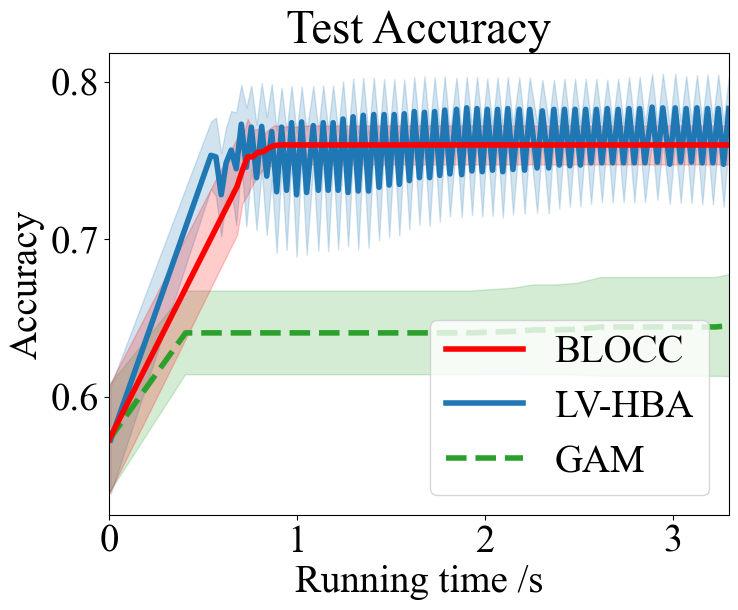

In [32]:
plt.figure(figsize=(8,6))

plt.plot(axis_lvhba,test_acc_lvhba.mean(0),'-',linewidth = 4, color = cmap(0),label="LV-HBA")
plt.fill_between(axis_lvhba,test_acc_lvhba.mean(0)-test_acc_lvhba.std(0),test_acc_lvhba.mean(0)+test_acc_lvhba.std(0),color = cmap(0),alpha=0.2)

plt.plot(axis_gam,test_acc_ga.mean(0),'--',linewidth = 4, color = cmap(2),label="GAM")
plt.fill_between(axis_gam,test_acc_ga.mean(0)-test_acc_ga.std(0),test_acc_ga.mean(0)+test_acc_ga.std(0),color = cmap(2),alpha=0.2)

plt.plot(axis_ours,test_acc_ours.mean(0),'-',linewidth = 4, color = 'r',label="BLOCC")
plt.fill_between(axis_ours,test_acc_ours.mean(0)-test_acc_ours.std(0),test_acc_ours.mean(0)+test_acc_ours.std(0),color = 'r',alpha=0.2)

# Get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Reorder the handles and labels as needed
order = [2,0,1]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
# Create the legend with the new order
plt.legend(ordered_handles, ordered_labels)

plt.title('Test Accuracy')
plt.xlabel('Running time /s')
plt.ylabel("Accuracy")

plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'test_accuracy_running_time.pdf', bbox_inches="tight")

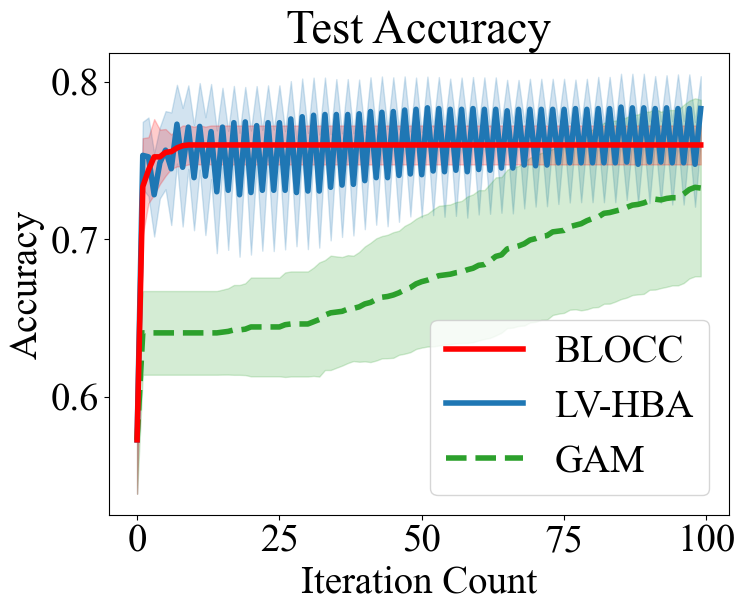

In [33]:
plt.figure(figsize=(8,6))

plt.plot(axis_iter,test_acc_lvhba.mean(0),'-',color = cmap(0),linewidth = 4, label="LV-HBA")
plt.fill_between(axis_iter,test_acc_lvhba.mean(0)-test_acc_lvhba.std(0),test_acc_lvhba.mean(0)+test_acc_lvhba.std(0),color = cmap(0),alpha=0.2)

plt.plot(axis_iter,test_acc_ga.mean(0),'--',color = cmap(2),linewidth = 4, label="GAM")
plt.fill_between(axis_iter,test_acc_ga.mean(0)-test_acc_ga.std(0),test_acc_ga.mean(0)+test_acc_ga.std(0),color = cmap(2),alpha=0.2)


plt.plot(axis_iter,test_acc_ours.mean(0),'-',color = 'r',linewidth = 4, label="BLOCC")
plt.fill_between(axis_iter,test_acc_ours.mean(0)-test_acc_ours.std(0),test_acc_ours.mean(0)+test_acc_ours.std(0),color = 'r',alpha=0.2)


plt.legend(ordered_handles, ordered_labels)

plt.title('Test Accuracy')
plt.xlabel('Iteration Count')
plt.ylabel("Accuracy")
plt.savefig(results_path + 'test_accuracy_iteration.pdf', bbox_inches="tight")

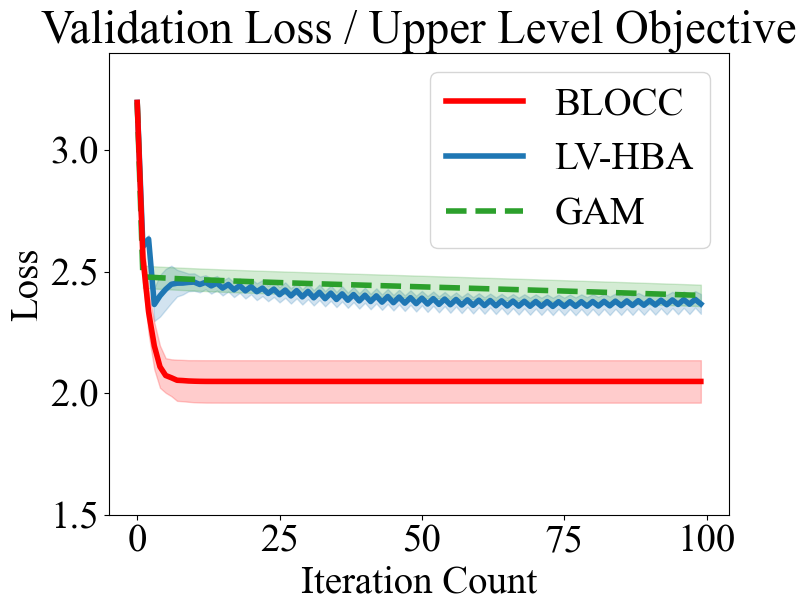

In [34]:
plt.figure(figsize=(8,6))


plt.plot(iter_axis,val_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = val_loss_lvhba.mean(0)-val_loss_lvhba.std(0)
fill_up_LV = val_loss_lvhba.mean(0)+val_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(iter_axis,val_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = val_loss_ga.mean(0)-val_loss_ga.std(0)
fill_dn_GAM = val_loss_ga.mean(0)+val_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(iter_axis,val_loss_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_ours = val_loss_ours.mean(0)-val_loss_ours.std(0)
fill_up_ours = val_loss_ours.mean(0)+val_loss_ours.std(0)
plt.fill_between(iter_axis[1:],fill_dn_ours[1:],fill_up_ours[1:],color = 'r', alpha=0.2)

plt.legend(ordered_handles, ordered_labels)

plt.title('Validation Loss / Upper Level Objective')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")


plt.ylim([1.5,3.4])
plt.savefig(results_path + 'upper_obj_iteration.pdf', bbox_inches="tight")

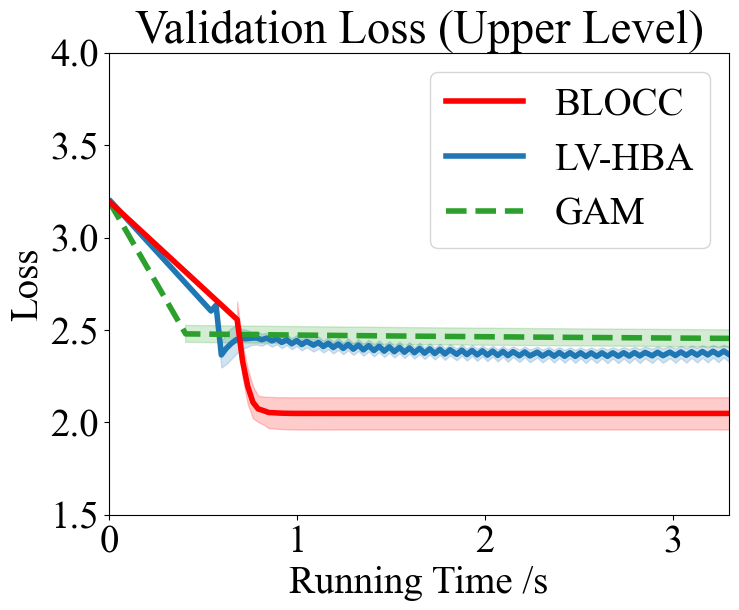

In [35]:
plt.figure(figsize=(8,6))


plt.plot(axis_lvhba,val_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = val_loss_lvhba.mean(0)-val_loss_lvhba.std(0)
fill_up_LV = val_loss_lvhba.mean(0)+val_loss_lvhba.std(0)
plt.fill_between(axis_lvhba[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(axis_gam,val_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = val_loss_ga.mean(0)-val_loss_ga.std(0)
fill_dn_GAM = val_loss_ga.mean(0)+val_loss_ga.std(0)
plt.fill_between(axis_gam[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(axis_ours,val_loss_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_ours = val_loss_ours.mean(0)-val_loss_ours.std(0)
fill_up_ours = val_loss_ours.mean(0)+val_loss_ours.std(0)
plt.fill_between(axis_ours[1:],fill_dn_ours[1:],fill_up_ours[1:],color = 'r', alpha=0.2)

plt.legend(ordered_handles, ordered_labels)
plt.title('Validation Loss (Upper Level)')
plt.xlabel('Running Time /s')
plt.ylabel("Loss")

plt.ylim([1.5,4])
plt.xlim([0,13])
plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'upper_obj_time.pdf', bbox_inches="tight")

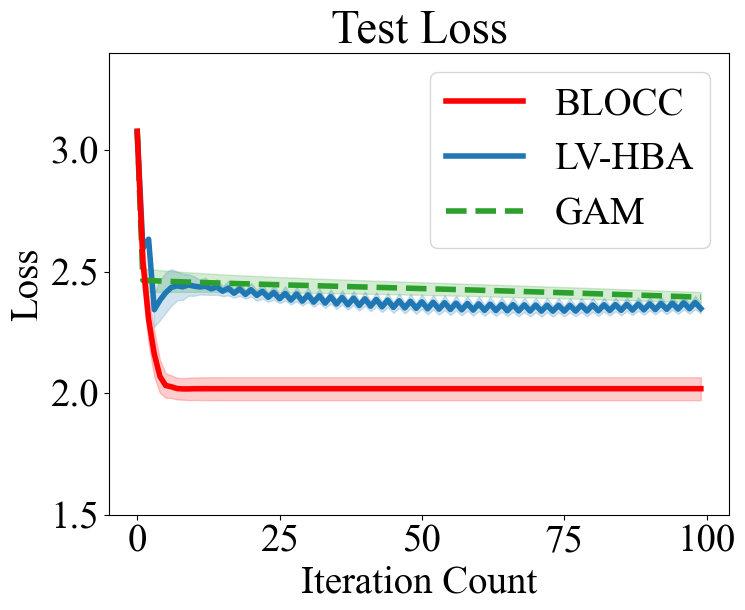

In [36]:
plt.figure(figsize=(8,6))

fill_dn_ours = test_loss_ours.mean(0)-test_loss_ours.std(0)
fill_up_ours = test_loss_ours.mean(0)+test_loss_ours.std(0)
plt.fill_between(iter_axis[1:],fill_dn_ours[1:],fill_up_ours[1:],color = 'r', alpha=0.2)

fill_dn_LV = test_loss_lvhba.mean(0)-test_loss_lvhba.std(0)
fill_up_LV = test_loss_lvhba.mean(0)+test_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

fill_up_GAM = test_loss_ga.mean(0)-test_loss_ga.std(0)
fill_dn_GAM = test_loss_ga.mean(0)+test_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(iter_axis,test_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")

plt.plot(iter_axis,test_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")

plt.plot(iter_axis,test_loss_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")


plt.legend(ordered_handles, ordered_labels)
plt.title('Test Loss')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")

plt.ylim([1.5,3.4])
plt.savefig(results_path + 'test_obj_iteration.pdf', bbox_inches="tight")

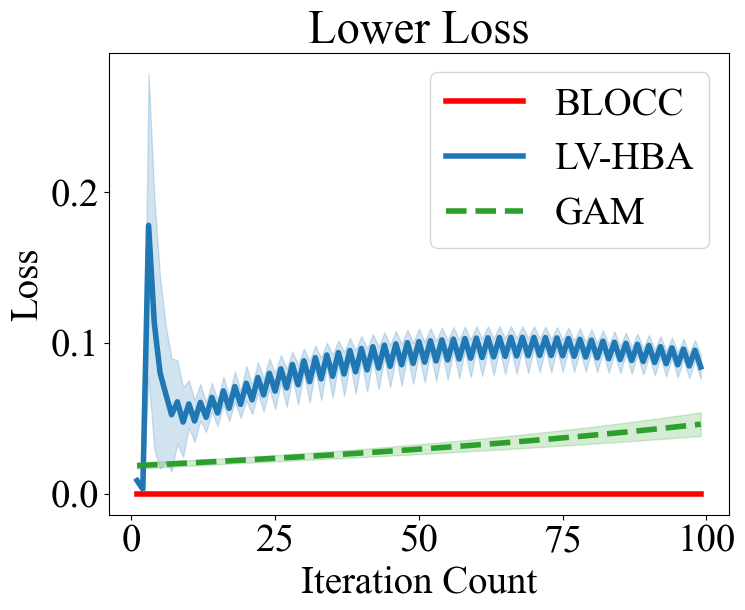

In [37]:
plt.figure(figsize=(8,6))

plt.plot(iter_axis[1:],lower_loss_ours.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
# fill_dn_ours = lower_loss_ours.mean(0)-lower_loss_ours.std(0)
# fill_up_ours = lower_loss_ours.mean(0)+lower_loss_ours.std(0)
# plt.fill_between(iter_axis[1:],fill_dn_ours,fill_up_ours,alpha=0.2)
# the above didn't work as the standard deviation is too small

plt.plot(iter_axis[1:],lower_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = lower_loss_lvhba.mean(0)-lower_loss_lvhba.std(0)
fill_up_LV = lower_loss_lvhba.mean(0)+lower_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV,fill_up_LV,color = cmap(0),alpha=0.2)

plt.plot(iter_axis[1:],lower_loss_ga.mean(0),'--', color = cmap(2),linewidth = 4, label="GAM")
fill_up_GAM = lower_loss_ga.mean(0)-lower_loss_ga.std(0)
fill_dn_GAM = lower_loss_ga.mean(0)+lower_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM,fill_up_GAM,color = cmap(2),alpha=0.2)

plt.legend()
plt.title('Lower Loss')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")

plt.savefig(results_path + 'lower_obj_iteration.pdf', bbox_inches="tight")

# Measuring Convergence Time
When `UpperLoss_{t+1}-UpperLoss_t` is smaller than `eps = 1e-6`. We say convergence happen.

In [38]:
# Find time for converges
# axis_lvhba_all, axis_gam_all, axis_ours_all are all of shape (10,80)
eps  = 1e-6
time_ours=axis_ours_all.flatten()[80*np.array(range(seeds))+np.argmax((test_acc_ours - test_acc_ours[:,-1][:, np.newaxis])**2<eps, axis = 1)]
time_lvhba=axis_lvhba_all.flatten()[80*np.array(range(seeds))+np.argmax((test_acc_lvhba - test_acc_lvhba[:,-1][:, np.newaxis])**2<eps, axis = 1)]
time_gam=axis_gam_all.flatten()[80*np.array(range(seeds)) + np.argmax((test_acc_ga - test_acc_ga[:,-1][:, np.newaxis])**2<eps, axis = 1)]


print("-------------- Running Time -------------")
print('Ours: {:0.3f}, {:0.3f}'.format(time_ours.mean(),time_ours.std()))
print('lvhba: {:0.3f}, {:0.3f}'.format(time_lvhba.mean(),time_lvhba.std()))
print('gam: {:0.3f}, {:0.3f}'.format(time_gam.mean(),time_gam.std()))

print("-------------- Accuracy -------------")
print('Ours: {:0.3f}, {:0.3f}'.format(test_acc_ours[:,-1].mean(),test_acc_ours[:,-1].std()))
print('lvhba: {:0.3f}, {:0.3f}'.format(test_acc_lvhba[:,-1].mean(),test_acc_lvhba[:,-1].std()))
print('gam: {:0.3f}, {:0.3f}'.format(test_acc_ga[:,-1].mean(),test_acc_ga[:,-1].std()))

-------------- Running Time -------------
Ours: 2.004, 0.803
lvhba: 1.875, 0.742
gam: 6.110, 3.467
-------------- Accuracy -------------
Ours: 0.760, 0.012
lvhba: 0.783, 0.021
gam: 0.733, 0.056
